<a href="https://colab.research.google.com/github/geoniesun/MB12/blob/master/Hotspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Methodology bases on Chen et al. 2019, National estimation of soil organic carbon storage potential for arable soils: A data-driven approach coupled with carbon-landscape zones. (https://doi.org/10.1016/j.scitotenv.2019.02.249).

Before using this script, you should have created the CDI layer with the privided R script: https://github.com/geoniesun/soc/blob/main/worldclim30seconds_cdicalculation.R

The created CDI should be uploaded as an asset in your Google Earth Engine account.

Read now carefully through this script and follow the instructions.

# Google login

Log into your GEE-account. Change the cloud project to yours, where you added the CDI tif.

In [ ]:
geeproject='ee-socseqhotspots'



### DO NOT CHANGE below !!





#install libraries
!pip install geopandas
!pip install pycrs #this has to be always installed..
!pip install rasterio
!pip install plotly==5.24.1

import geemap
import ee
import os
import pycrs
import geemap.colormaps as cm
import geopandas as gpd
import glob
from osgeo import gdal



# Authenticate
ee.Authenticate()


#Initialize Project
ee.Initialize(project=geeproject) ##change here to your own project

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=0293cd425aaccc29d7cd80f6ae831a6fc164bc984a8de5b2b64a78880a2a8f2e
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.1 MB/s eta 0:00:00


# Data collection and filter settings

To upload your AOI shapefile, you can use the following two snippets. For me, the second one was more efficient.

In [ ]:
# searching for assets
# geemap.ee_search()

In [ ]:
# from google.colab import files #upload here your AOI
# files.upload()

## Data

After uploading the CDI map in your GEE project, setting your GEE cloud project and uploading your AOI shapefile you will import here all data.


In case you will use another data than in this example for e.g. Fine Fraction, please note that you then will have to adjust small changes later on. But these will be pointed out in these sections.

Please think about the units of your data and to keep it constant or converting it.

In [ ]:
## Data collection


## Soil Organic Carbon map
soc = ee.Image("projects/soilgrids-isric/soc_mean")



## Silt and Clay maps
clay =  ee.Image("projects/soilgrids-isric/clay_mean")
silt = ee.Image("projects/soilgrids-isric/silt_mean")



##Bulk Density
bd = ee.Image("projects/soilgrids-isric/bdod_mean")



## CDI Map
cdi = ee.Image("projects/ee-socseqhotspots/assets/cdi_perMonth30s")




## AOI shapefiles.
llanos_shp = geemap.shp_to_ee("/content/drive/MyDrive/CIAT/losllanos_diss_4326.shp")


# soil samples (CIAT)
shp_path = "/content/drive/MyDrive/CIAT/bindedSOCcm30_tonha_all.shp"


Check now the resolution of your data to define it after this snippet. You need to uncomment (Ctrl#) first.

In [ ]:
# print('Resoltion silt map: ', silt.projection().nominalScale().getInfo(),'; Resolution clay map:', clay.projection().nominalScale().getInfo(),
#       '; Resolution soc map:', soc.projection().nominalScale().getInfo(), '; Resolution cdi map:', cdi.projection().nominalScale().getInfo() )

Define here:
- coordinate system
- scale
- aoi


In [ ]:
crs = "EPSG:4326"   ## change your CRS

scale = 250   ## set your scale

aoi = llanos_shp ## Set here your selected AOI





## DONT CHANGE below!!


# necessary for some processing steps
aoigeo = aoi.geometry()



If wished, you can check some properties here of your input data. Uncomment the one you want to look at and run.

In [ ]:
### check layers

silt
# cdi
# clay
#soc
# aoi
#FF



## Visuals

You can set your visuals here.

In [ ]:
import geemap.colormaps as cm


vis_cdi = {
    "min": 0,
    "max": 3,
    "palette": ["#355834", "#CDD1C4"],}




vis_soc_dgkg = {
    "min": 50,
    "max": 2000,
    "palette": ["#4C230F", "#D4DF9E"],
                }

vis_ff = {
    "min": 100,
    "max": 600,
    "palette": ["#4C230F", "#D4DF9E"],
                }

vis_soc_tonha = {
    "min": 10,
    "max": 500,
    "palette": ["#4C230F", "#D4DF9E"],
                }




# cm.list_colormaps() #to see what palettes there are

# #getting value range
# stat_dict = cdi.reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=aoi,
#     scale=1000,
#     maxPixels=1e9
# )


# min_max_values = stat_dict.getInfo()
# print("Min-/Max-Werte:", min_max_values)

## Clipping

Now we clip our data to make processing faster.  In case you use another data, you can easily adjust here the code.
If you have e.g. data for fine fraction already in one Image (and not as in this example in two: silt and clay), then just clip your fine fraction image here as e.g.:

ffclip = ff.clip(aoi)

Remove or add thus layers, depening on what you have.

These clipped images will be the base for the PCA. If you add another image in the clipping section, you need to add/adjust it also in the PCA section. See PCA of Fine Fraction for an example how to adjust the input there in case.



In [ ]:
# clipping to aoi

socclip = soc.clip(aoi)
siltclip = silt.clip(aoi)
clayclip = clay.clip(aoi)
cdiclip = cdi.clip(aoi)
bdclip = bd.clip(aoigeo)


print("clayclip: ", clayclip.bandNames().getInfo())   # in case you want to know the band names
# print("socclip :", socclip.bandNames().getInfo())
# print("siltclip :", siltclip.bandNames().getInfo())

clayclip:  ['clay_0-5cm_mean', 'clay_5-15cm_mean', 'clay_15-30cm_mean', 'clay_30-60cm_mean', 'clay_60-100cm_mean', 'clay_100-200cm_mean']


You can now visualise the first impressions of the data. Add/remove layers if needed. Uncomment first.

In [ ]:
# #visualize just for first impression

# map = geemap.Map()
# map.add_layer(socclip.select(['soc_15-30cm_mean']), vis_soc_dgkg, "socclip")
# map.add_layer(clayclip.select(['clay_0-5cm_mean']), vis_ff, "clayclip")
# map.add_layer(siltclip.select(['silt_0-5cm_mean']), vis_ff, "siltclip")
# map.add_layer(cdiclip.select(['b2']), vis_cdi, "cdiclip")
# map.centerObject(aoi, zoom = 7)
# map

#Functions

The section "Functions" you can run entirely without checking anything.

In [ ]:

def boundaryline (chosen_percentil = 3, export = True):






  selected_BLpercentage = grouped_descriptions[[str(f"{int(percentiles[chosen_percentil]*100)}%")]]



  # selected_BLpercentage['Cluster'] = list(range(len(selected_BLpercentage.index)))
  selected_BLpercentage['Cluster'] = selected_BLpercentage.index
  print(selected_BLpercentage.head())


  #includes our BLA information of each cluster


  import numpy as np
  import pandas as pd
  import matplotlib as mpl
  !pip install rasterio
  import rasterio



  # our raster we want to update with new SOC data: aoi_r
  aoi_r = rasterio.open(raster_path)
  aoi_r_array = aoi_r.read(1)



  columns_with_percent = [col for col in selected_BLpercentage.columns if '%' in col]

  clustersocdict = selected_BLpercentage.set_index('Cluster')[columns_with_percent].to_dict()



  main_key = list(clustersocdict.keys())[0]

  clusterdic = clustersocdict[main_key]


  aoi_r_array_copy = np.copy(aoi_r_array)
  for cluster, soc in clusterdic.items():
      aoi_r_array_copy[aoi_r_array_copy == cluster] = soc

  oscmaxbl = aoi_r_array_copy


  fig, ax = plt.subplots()
  img = mpl.pyplot.imshow(oscmaxbl)
  ax.set_aspect("auto")
  ax.set_title(f"Max SOC [ton/ha] per CLZ - BLA {int(percentiles[chosen_percentil]*100)}%. Used model: {modelused}")
  plt.colorbar(img)

## EXPORTING. NO NEED TO CHANGE
  if export is True:
    export_array_to_geotiff(exportingarray=oscmaxbl, output_file=f"{modelused}_{int(percentiles[chosen_percentil]*100)}_maxSOC.tif")

In [ ]:
## DONT CHANGE THIS SNIPPET !!!!!!
















## PCA function converted to python api as from (https://www.lifeingis.com/computation-of-principal-component-analysis-in-the-google-earth-engine/  [last visited: 16/12/2024])

def PCA(maskedImage):


  image = maskedImage.unmask()
  scale = 250
  region = aoi
  bandNames = image.bandNames()

  meanDict = image.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = region,
    scale = scale,
    maxPixels = 1e9,
    bestEffort = True,
    tileScale = 16
  )
  means = ee.Image.constant(meanDict.values(bandNames))
  centered = image.subtract(means)

  def getNewBandNames(prefix):
    seq = ee.List.sequence(1, bandNames.length())
    new_band_names = seq.map(lambda b: ee.String(prefix).cat(ee.Number(b).int()))
    return new_band_names

  def getPrincipalComponents(centered, scale, region):
    arrays = centered.toArray()

    covar = arrays.reduceRegion(
    reducer = ee.Reducer.centeredCovariance(),
    geometry = region,
    scale = scale,
    maxPixels = 1e9,
    bestEffort = True,
    tileScale = 16)

    covarArray = ee.Array(covar.get('array'))
    eigens = covarArray.eigen()
    # This is a P-length vector of Eigenvalues.
    eigenValues = eigens.slice(1, 0, 1)

    # // Compute Percentage Variance of each component
    eigenValuesList = eigenValues.toList().flatten()
    total = eigenValuesList.reduce(ee.Reducer.sum())

    percentageVariance = eigenValuesList.map(
        lambda item: ee.Number(item).divide(total).multiply(100).format('%.2f'))


    # This will allow us to decide how many components capture
    # most of the variance in the input
    percentage_variance_info = percentageVariance.getInfo()
    print('Percentage Variance of Each Component:', percentage_variance_info)
    # This is a PxP matrix with eigenvectors in rows.
    eigenVectors = eigens.slice(1, 1)
    # Convert the array image to 2D arrays for matrix computations.
    arrayImage = arrays.toArray(1)
    # Left multiply the image array by the matrix of eigenvectors.
    principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

    # Turn the square roots of the Eigenvalues into a P-band image.
    sdImage = ee.Image(eigenValues.sqrt()).arrayProject([0]).arrayFlatten([getNewBandNames('sd')])
    return principalComponents.arrayProject([0]).arrayFlatten([getNewBandNames('pc')]).divide(sdImage)

  pcImage = getPrincipalComponents(centered, scale, region)
  return pcImage.mask(maskedImage.mask())


In [ ]:
## DONT CHANGE below !!!








!pip install rasterio
import rasterio
from rasterio.transform import Affine
from rasterio.transform import from_bounds



def export_array_to_geotiff(exportingarray, output_file='exportingarray.tif'):

  geobounds = aoigeo.bounds().getInfo()
  print(geobounds)


  bounds = aoigeo.bounds()

  coordinates = bounds.coordinates().getInfo()

  lon_values = [coord[0] for coord in coordinates[0]]
  lat_values = [coord[1] for coord in coordinates[0]]

  min_lon = min(lon_values)
  max_lon = max(lon_values)
  min_lat = min(lat_values)
  max_lat = max(lat_values)


  min_lon, max_lon = min_lon, max_lon
  min_lat, max_lat = min_lat, max_lat


  rows, cols = exportingarray.shape

  x = np.linspace(min_lon, max_lon, cols)
  y = np.linspace(max_lat, min_lat, rows)
  X, Y = np.meshgrid(x, y)
  xres = (x[-1] - x[0]) / len(x)
  xres
  yres = (y[-1] - y[0]) / len(y)
  yres



  transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)
  print(transform)

  height=exportingarray.shape[0]



  with rasterio.open(
     output_file,
     'w',
     driver='GTiff',
     height=exportingarray.shape[0],
     width=exportingarray.shape[1],
     count=1,
     dtype=exportingarray.dtype,
     crs='+proj=latlong',
     transform=transform,
  ) as dst:
      dst.write(exportingarray, 1)

  from google.colab import files
  files.download(output_file)


In [ ]:
## DONT CHANGE below !!

























# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):

    # X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

# Principal Component Analysis

Chen et al. 2019 used the PCA only for the CDI data. Why could and should we use the PCA as well for our soil and SOC data ? Our soil and soc data (by soilgrids) contains more bands than in the study by Chen et al. 2019. For the GMM it is best not to reach over 15 input bands. Chen et al. 2019 used 9 bands for the GMM. By reducing our soil and soc bands with the PCA we then can reach also 9 bands (depends as well on how many PC we choose in each category).
This is, because for each category e.g. "Fine Fraction", we will choose around 3 PC which act as bands. So if we have three categories (CDI, Fine Fraction and SOC current), we will reach around 3*3 bands = 9 bands.  

In the first example, using the CDI, I explain each step.


## PCA for CDI

First we set the image on which we will run the PCA-function. This is the clipped image.

In [ ]:
## DONT CHANGE below






cdiclip = ee.Image(cdiclip)

cdiclipscaled = cdiclip.reproject(crs = crs, scale = scale)


pca_img_cdi = cdiclipscaled ##this image is now our image for the PCA

As we run the PCA function, we will get as an output as well the percentage of variance explained by each principal component (PC). We want to select the PCs that explain accumulated minimum 95% of the variance. In both examples for Colombia and Kenya we choose the 3 first PC. Change the .select([]) input depending on your case.

Future work: make it automatic

In [ ]:
# selecting the 3 first PC as they explain more than 95% of the variance. Adjust selected PC to reach 95%

pca_cdi = PCA(pca_img_cdi).select(['pc1', 'pc2', 'pc3'])



Percentage Variance of Each Component: ['46.71', '37.74', '10.90', '2.77', '1.78', '0.05', '0.03', '0.01', '0.01', '0.00', '0.00', '0.00']


In [ ]:
# pca_cdi #output is an image

For a first impression we can visualize the PCs. The values of the principal components represent the relative contribution of each pixel to the variance captured by the respective component.So positive and negative values indicate correlations with dominant patterns or features in the original data.

In [ ]:
#visualize pca output
pcamap = geemap.Map()


pcamap.add_layer(pca_cdi.select(['pc1']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc1")
pcamap.add_layer(pca_cdi.select(['pc2']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc2")
pcamap.add_layer(pca_cdi.select(['pc3']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc3")

# PCs als RGB kombinieren
rgb_viz = pca_cdi.select(['pc1', 'pc2', 'pc3'])
pcamap.add_layer(rgb_viz, {'min': -2, 'max': 2}, 'RGB PCA')

pcamap.center_object(aoi, 7)
pcamap

Map(center=[4.577287979407777, -71.10913876926482], controls=(WidgetControl(options=['position', 'transparent_…

## PCA of Fine Fraction

---



Chen et al. 2019 only used clay maps for top and subsoil. In total they used 9 bands for the GMM.
As we have more information about fine fraction (18 bands in total) we should also add PCA here.

In this example for fine fraction we have two images (silt and clay) which we first have to define as fine fraction (as one image with silt and clay bands).
In case you have, e.g. already a fine fraction image, then create anyways an image collection with only one image (see comment at FF_imgcol variable).

In [ ]:
#first we need to create one image out of the fine fraction images (clay and silt)

FF_imgcol = ee.ImageCollection.fromImages(
    [ee.Image(clayclip), ee.Image(siltclip)])   # or only one image if you have one for Fine Fraction. You still need to keep it as an image collection







FF_img = FF_imgcol.toBands()
FF_img = FF_img.reproject(crs= crs, scale=scale)
FF_img = FF_img.clip(aoigeo) #clipping again even if already done, was necessary to create exact pixel limits for the later rasterization
#FF_img

In [ ]:
pca_FF = PCA(FF_img).select(['pc1', 'pc2', 'pc3']) #we select the PC that explain more than 95%

Percentage Variance of Each Component: ['69.41', '23.44', '5.27', '0.75', '0.39', '0.25', '0.19', '0.14', '0.07', '0.04', '0.03', '0.02']


In [ ]:
# pcamap_finefraction = geemap.Map()

# pcamap_finefraction.add_layer(pca_FF.select(['pc1']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc1")
# pcamap_finefraction.add_layer(pca_FF.select(['pc2']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc2")
# pcamap_finefraction.add_layer(pca_FF.select(['pc3']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc3")
# #pcamap_finefraction.add_layer(pca_FF.select(['pc4']), {'min': -2, 'max': 2, 'palette': ['blue', 'white', 'red']}, "pc4")
# pcamap_finefraction.centerObject(aoi, zoom = 7)



# pcamap_finefraction

## PCA of SOC

Also the SOC data has several bands (6 in this case) that we should break down to at least 3.

In [ ]:
socclip_col = ee.ImageCollection.fromImages(
    [ee.Image(socclip)])





soc_img = socclip_col.toBands()
soc_img = soc_img.reproject(crs=crs, scale=250)
soc_img = soc_img.clip(aoigeo)
#soc_img

In [ ]:
pca_soc = PCA(soc_img).select(['pc1', 'pc2']) #change depending on the percentiage variance output (95%)


Percentage Variance of Each Component: ['90.94', '5.40', '2.22', '1.10', '0.30', '0.04']


Example Los LLanos: For the SOC already 2 PC explain over 95% of the variance which is why we selected only 2 PC.

# Clustering

## Clustering Data Preparation

Let's prepare the data for clustering.
That is all  PCA outputs with their selected PCs (This example: 3 PCA outputs)
of the collection we then create ***one*** image with the PCAs as bands.

From here on the cloud computer only will allow calculation with a scale of 1000m. Depending on the size of your area you can try to get a better resolution.

For the clustering we need a 2D array. So we convert the image first to a numpy array to then convert it to a 2D array. This is where we have a limitation of around 1000m scale (depends also on your input aoi size) on the cloud computing platform (using the function ee_to_numpy).



In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform



hcol = ee.ImageCollection.fromImages(
    [ee.Image(pca_soc), ee.Image(pca_cdi), ee.Image(pca_FF)]) #here we insert all pca-output images we created in the PCA-section. Add or remove if needed.




## DONT CHANGE below





himg = hcol.toBands()
himg = himg.unmask(9999)  # in case of NAs
himg = himg.clip(aoigeo.bounds())


bands_himg = himg.bandNames().getInfo()


himg_np = geemap.ee_to_numpy(himg, region = aoi, scale=1000, bands= bands_himg)



# print(himg_np.shape)


band_names = himg.bandNames().getInfo()

band_count = himg.bandNames().size().getInfo()

himg_np[himg_np == 9999] = np.nan


# as we need a 2d array we need to reshape it first
reshapedarray = himg_np.reshape(-1, band_count)  #https://www.w3schools.com/python/numpy/numpy_array_reshape.asp#:~:text=Flattening%20the%20arrays,(%2D1)%20to%20do%20this.


#and then scale it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(reshapedarray)

scaled[np.isnan(scaled)] = 9999



Before doing the actual clustering process, we first need to define how many clusters we want to create. For that, the next chapter should help to guide you to a desicion. We test cluster tendency and the recommended amount of clusters. Also we will compare the cluster amount visually and compare results from a Gaussian Mixture Model and K-means.
If you want to jump over this section, go to "Final model to be used & preparation for export".

  

  
  
  


## Test Cluster Tendency



Testing the cluster tendency is useful to understand if our data is actually "clusterable".

(pyclustertend would be a good library but is not available on colab, so we do it manually as in:
 https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb, [last viewed December 2024])

In [ ]:
##DONT CHANGE


#calculating the hopkins statistic
print(hopkins_statistic(scaled)) #the closer to 1 the better


0.9999870635646632


##Finding number of clusters (CLZs) using BIC and plots




### Estimate N cluster GMM

We want to find out which number of cluster is suited for our case. This snipped runs for a while (approx 20 min). Chen et al. 2019 used only BIC.

First for GMM, then later for Kmeans.



Optimal number of clusters with GMM (relative difference method): 7


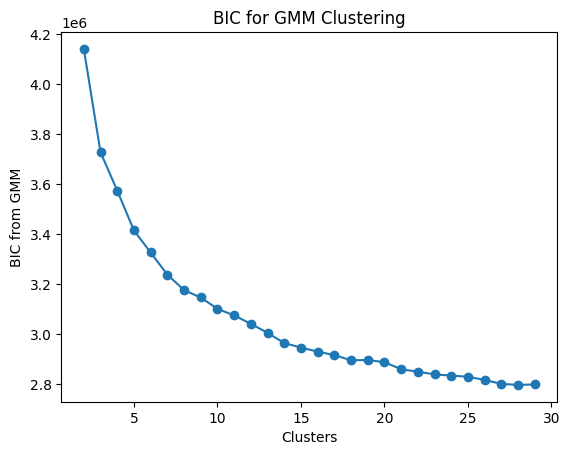

In [ ]:
## ## RUNTIME: 30-60 min !!!












## DONT CHANGE below !!!










import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio
from sklearn.mixture import GaussianMixture



n_components = range(2, 30)
bic_scores = []
# aic_values = []



valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_m)

    bic_scores.append(gmm.bic(scaled_m))
    # aic_values.append(gmm.aic(scaled_m))


# relative difference
relative_bic_diff = [(bic_scores[i-1] - bic_scores[i]) / abs(bic_scores[i-1])
                     for i in range(1, len(bic_scores))]
threshold = 0.01
optimal_clusters = next((i + 1 for i, diff in enumerate(relative_bic_diff) if diff < threshold), len(n_components))

print('Optimal number of clusters with GMM (relative difference method):', optimal_clusters)


N = np.arange(2, 30)
plt.plot(N, bic_scores, marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC from GMM')
plt.title('BIC for GMM Clustering')
plt.show()

### Estimate N cluster Kmeans

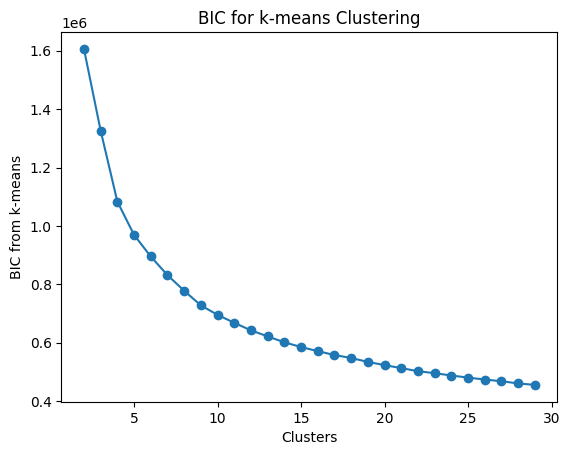

In [ ]:
## RUNTIME: 30-60 min !!!




n_components = range(2, 30)  # Testing 2 to 30 Cluster (you can start with 15 and see if that is maybe already enough for testing)





## DONT CHANGE below !!!










from sklearn.cluster import KMeans


valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


def kmeans_bic(fit):
    m = fit.cluster_centers_.shape[1]
    n = len(fit.labels_)
    k = fit.n_clusters
    D = fit.inertia_
    return D + np.log(n) * m * k


bic_k = [
    kmeans_bic(
        KMeans(n_clusters=k, n_init=42, max_iter=25, random_state=42).fit(scaled_m)
    )
    for k in n_components
]


plt.plot(n_components, bic_k, marker='o')
plt.xlabel('Clusters')
plt.ylabel('BIC from k-means')
plt.title('BIC for k-means Clustering')
plt.show()


#https://bgstieber.github.io/post/an-introduction-to-the-kmeans-algorithm/


This gives us an idea of what number of clusters could be used. Anyways it is good to compare visually different N.

### Gaussian Mixture Model

In the original study they had after PCAs 9 bands. We have now also around 8 bands (depending on our PC selection). A GMM should work fine with that amount

As an example on the Colombia data:
- 3 from the PCA of CDI
- 3 from the PCA of Fine Fraction
- 2 from the PCA of SOC

#### Plot GMM different cluster N

Now we use the gmm with the estimated cluster n by bic (and aic) from before.

We already prepared the data in "Test Cluster Tendendy"
our last array to use now is "scaled".

you can now ajust the number of clusters you want to compare in the list "n_list" at the top of the next snippet.

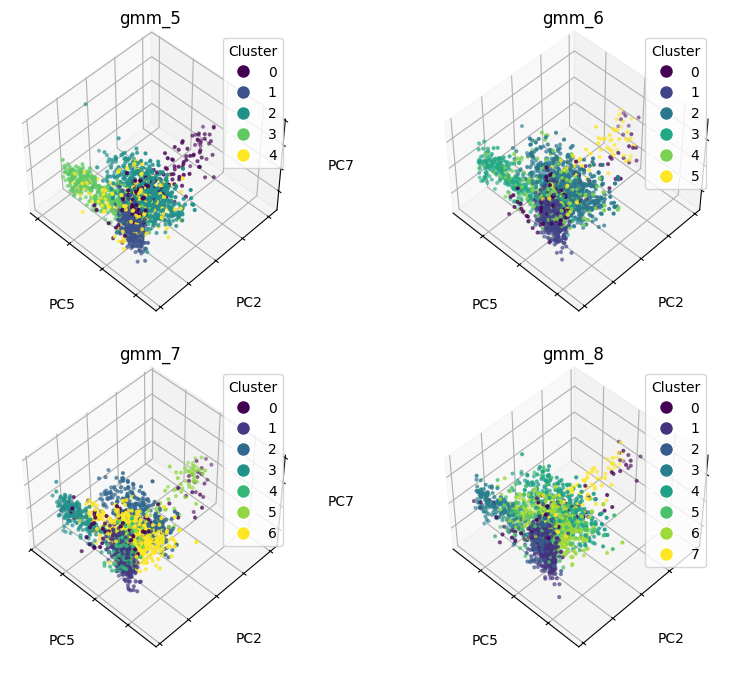

In [ ]:
n_list = [5,6,7,8] # change here the number of clusters to be looked at

#selecting dimensions to look at
dim_x = 5  # you can change the dimensions
dim_y = 2
dim_z = 7










## DONT CHANGE below !!!!






import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


estimators = [
    (f"gmm_{n}", GaussianMixture(n_components = n, random_state=42))
    for n in n_list
]

titles = [f"gmm_{n}" for  n in n_list]






fig = plt.figure(figsize=(10, 8))


for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(scaled_m)
    labels = est.predict(scaled_m)

    sample_size = 2000

    sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
    sampled_data = scaled_m[sample_indices]
    sampled_labels = labels[sample_indices]


    unique_labels = np.unique(sampled_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
    for i, label in enumerate(unique_labels)]


    ax.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labels,cmap='viridis', s=4)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel(f"PC{dim_x}")
    ax.set_ylabel(f"PC{dim_y}")
    ax.set_zlabel(f"PC{dim_z}")
    ax.set_title(title)
    ax.legend(handles=legend_handles, title="Cluster")




#### Plot single GMM model

Change your cluster to look at in "chosen_cluster" and run. Then you can run the coming three snippets to have a look on your clusters in 2D, 3D and 3D interactive.

In [ ]:
chosen_cluster = 8 #change here your chosen cluster









##### DONT CHANGE BELOW !!!







import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

gmm = GaussianMixture(n_components =chosen_cluster, random_state=42) #change n_components depening on your bic result

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]

gmm.fit(scaled_m) #fitting
labels = gmm.predict(scaled_m) #predicting


# print(gmm.get_params())
centers = gmm.means_
centers.shape #creating the centers of the clusters

sample_size = 5000
sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
sampled_data = scaled_m[sample_indices]
sampled_labels = labels[sample_indices]


unique_labels = np.unique(sampled_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
    for i, label in enumerate(unique_labels)
]



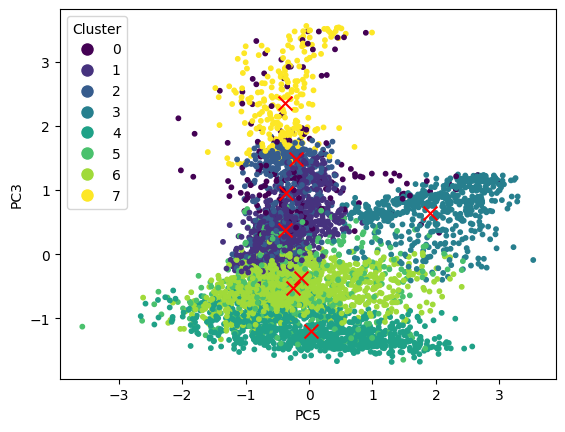

In [ ]:
##plotting 2D

##selecting dimensions to look at
dim_x = 5
dim_y = 3


## DONT CHANGE BELOW




plt.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], c=sampled_labels, cmap='viridis', s=10, label=unique_labels)
plt.legend()
plt.scatter(centers[:,dim_x], centers[:,dim_y], c='red', marker='x', s=100, label='Cluster Centers')
plt.xlabel(f"PC{dim_x}")
plt.ylabel(f"PC{dim_y}")
plt.legend(handles=legend_handles, title="Cluster")

plt.show()

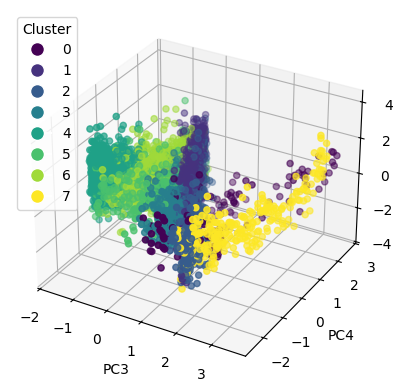

In [ ]:
#selecting dimensions to look at
dim_x = 3
dim_y = 4
dim_z = 6


## DONT CHANGE BELOW




from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(scaled[sample_indices, dim_x], scaled[sample_indices, dim_y], scaled[sample_indices, dim_z], c=sampled_labels, cmap='viridis')
ax.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices, dim_z], c=sampled_labels, cmap='viridis')

ax.set_xlabel(f"PC{dim_x}")
ax.set_ylabel(f"PC{dim_y}")
ax.set_zlabel(f"PC{dim_z}")
ax.legend(handles=legend_handles, title="Cluster")
# plt.title("GMM Results")
plt.show()


In [ ]:
#selecting dimensions to look at
dim_x = 3#3
dim_y = 5#6
dim_z = 7#4




## DONT CHANGE BELOW !!!








import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import plotly.express as px

x = sampled_data[0:,dim_x]
y = sampled_data[0:,dim_y]
z = sampled_data[0:,dim_z]


df = pd.DataFrame({
    f'Dimension {dim_x}': x,
   f'Dimension {dim_y}': y,
    f'Dimension {dim_z}': z,
    'Cluster Label': sampled_labels
})

df["Cluster Label"] = df["Cluster Label"].astype("str")

category_orders = {"Cluster Label": [str(i) for i in range(chosen_cluster)]}



fig = px.scatter_3d(df, x = f'Dimension {dim_x}', y = f'Dimension {dim_y}', z = f'Dimension {dim_z}', color = 'Cluster Label', opacity=0.7, category_orders = category_orders)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(size=4))
fig.show()




### K-means

Here you can have a look into clustering with kmeans. Change also here the number of clusters you want to compare in "n_list".

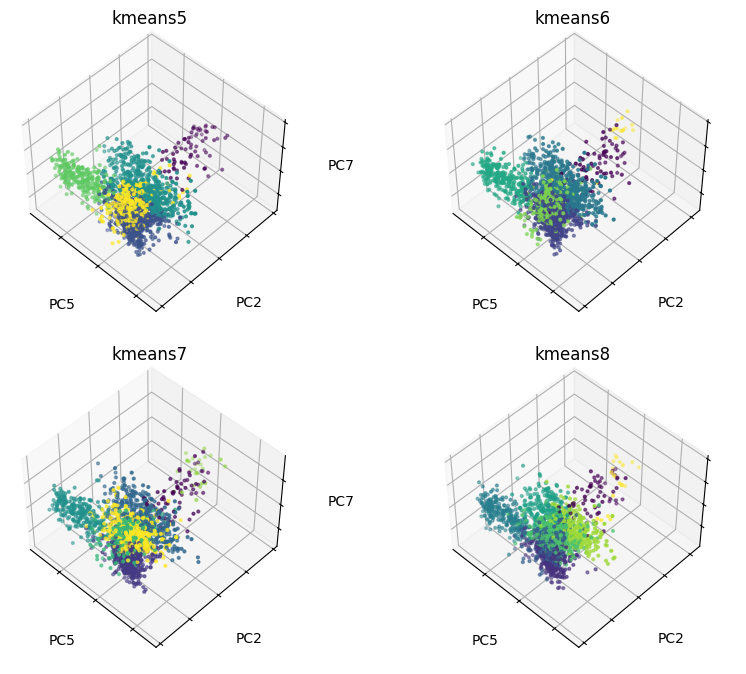

In [ ]:
# change here the number of clusters to be looked at
n_list = [5,6,7,8]



#selecting dimensions to look at
dim_x = 5
dim_y = 2
dim_z = 7






## DONT CHANGE below !!!!











import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


estimators = [
    (f"kmeans{n}", KMeans(n_clusters=n, random_state=42))
    for n in n_list
]

titles = [f"kmeans{n}" for  n in n_list]



fig = plt.figure(figsize=(10, 8))

for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(scaled_m)
    labels = est.labels_

    sample_size =2000

    sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
    sampled_data = scaled_m[sample_indices]
    sampled_labels = labels[sample_indices]


    unique_labels = np.unique(sampled_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
        for i, label in enumerate(unique_labels)]

    ax.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labels,cmap='viridis', s=4)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel(f"PC{dim_x}")
    ax.set_ylabel(f"PC{dim_y}")
    ax.set_zlabel(f"PC{dim_z}")
    ax.set_title(title)
    # ax.legend(handles=legend_handles, title="Cluster")




### K-meas vs. GMM

Here we can compare GMM and Kmeans with a chosen number of cluster. Set that number in "chosen_cluster" and run. Then run the following two snippets to compare visually the models in 2D and interactive 3D.  

In [ ]:
#choose your cluster N to be compared between Kmeans and GMM
chosen_cluster = 8





## DONT CHANGE below !!












## data prep and model fitting

valid_mask = np.all(scaled != 9999, axis=1) #to exlude 9999 (NaN) values. NaN values can't be read by GMM, only 9999 for example
scaled_m = scaled[valid_mask]


sample_size = 2000
sample_indices = np.random.choice(len(scaled_m), sample_size, replace=False)
sampled_data = scaled_m[sample_indices]


gmm = GaussianMixture(n_components = chosen_cluster, random_state=42).fit(scaled_m)
labelsgmm = gmm.predict(scaled_m)
sampled_labelsgmm = labelsgmm[sample_indices]


kmeans = KMeans(n_clusters=chosen_cluster, random_state=42).fit(scaled_m)
labelsk = kmeans.labels_
sampled_labelsk = labelsk[sample_indices]


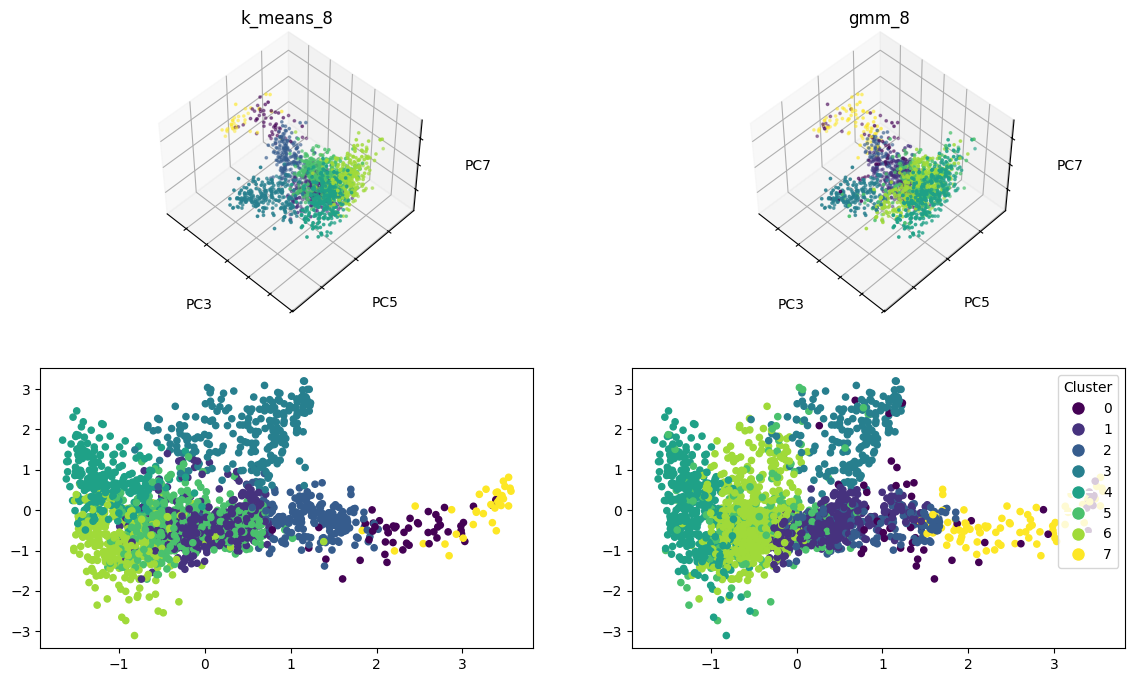

In [ ]:
#selecting dimensions to look at
dim_x = 3#3
dim_y = 5#6
dim_z = 7#4







## DONT CHANGE below !!











import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap


fig = plt.figure(figsize=(14, 8))

titles = [f"k_means_{chosen_cluster}", f"gmm_{chosen_cluster}"]

unique_labels = np.unique(sampled_labelsk)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'{label}')
    for i, label in enumerate(unique_labels)
]


ax1 = fig.add_subplot(2, 2, 1, projection="3d", elev=48, azim=134)
ax1.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labelsk,cmap='viridis',s=3)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.zaxis.set_ticklabels([])
ax1.set_xlabel(f"PC{dim_x}")
ax1.set_ylabel(f"PC{dim_y}")
ax1.set_zlabel(f"PC{dim_z}")
ax1.set_title(titles[0])



ax2 = fig.add_subplot(2, 2, 2, projection="3d", elev=48, azim=134)
ax2.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], scaled_m[sample_indices,dim_z], c=sampled_labelsgmm, cmap='viridis',s=3)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.zaxis.set_ticklabels([])
ax2.set_xlabel(f"PC{dim_x}")
ax2.set_ylabel(f"PC{dim_y}")
ax2.set_zlabel(f"PC{dim_z}")
ax2.set_title(titles[1])


ax3 = fig.add_subplot(2,2,3)
ax3.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], c=sampled_labelsk, cmap='viridis', s=20)
# ax3.scatter(centers[:,2], centers[:,4], c='red', marker='x', s=100, label='Cluster Centers')
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(scaled_m[sample_indices, dim_x], scaled_m[sample_indices, dim_y], c=sampled_labelsgmm, cmap='viridis', s=20)
ax4.legend(handles=legend_handles, title="Cluster")
# ax4.scatter(centers[:,2], centers[:,4], c='red', marker='x', s=100, label='Cluster Centers')


plt.show()

3D interactive for GMM:

In [ ]:
#selecting dimensions to look at
dim_x = 3#3
dim_y = 5#6
dim_z = 7#4






## DONT CHANGE BELOW !!!!









import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import plotly.express as px

x = sampled_data[0:,dim_x]
y = sampled_data[0:,dim_y]
z = sampled_data[0:,dim_z]



#gmm
dfgmm = pd.DataFrame({
    f'Dimension {dim_x}': x,
   f'Dimension {dim_y}': y,
    f'Dimension {dim_z}': z,
    'Cluster Label': sampled_labelsgmm
})

dfgmm["Cluster Label"] = dfgmm["Cluster Label"].astype("str")

category_orders = {"Cluster Label": [str(i) for i in range(chosen_cluster)]}



fig = px.scatter_3d(dfgmm, x = f'Dimension {dim_x}', y = f'Dimension {dim_y}', z = f'Dimension {dim_z}', color = 'Cluster Label', opacity=0.7, category_orders = category_orders, title =f"GMM{chosen_cluster} Clusters")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(size=4))
fig.show()



For Kmeans:

In [ ]:
#selecting dimensions to look at
dim_x = 3#3
dim_y = 5#6
dim_z = 7#4





## DONT CHANGE below !!










import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import plotly.express as px




x = sampled_data[0:,dim_x]
y = sampled_data[0:,dim_y]
z = sampled_data[0:,dim_z]



#kmeans
dfkmeans = pd.DataFrame({
    f'Dimension {dim_x}': x,
   f'Dimension {dim_y}': y,
    f'Dimension {dim_z}': z,
    'Cluster Label': sampled_labelsk
})

dfkmeans["Cluster Label"] = dfkmeans["Cluster Label"].astype("str")

category_orders = {"Cluster Label": [str(i) for i in range(chosen_cluster)]}



fig1 = px.scatter_3d(dfkmeans, x = f'Dimension {dim_x}', y = f'Dimension {dim_y}', z = f'Dimension {dim_z}', color = 'Cluster Label', opacity=0.7, category_orders = category_orders)
fig1.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig1.update_traces(marker=dict(size=4))

fig1.show()

## Final model to be used & preparation for export

After having decided on a cluster number you will run your preferred model now again. Set your cluster/CLZ number as "chosen_n" in the top of the code below.



FYI: your array contains missing values. So your cluster number in your output will be set to 16 clusters to give the missing values an extra cluster. This extra cluster you can delete in the end after exporting.
We need that shape:  (611, 838, 8)
Our current shape: (512018, 8)
Shape after transforming:  (611, 838)


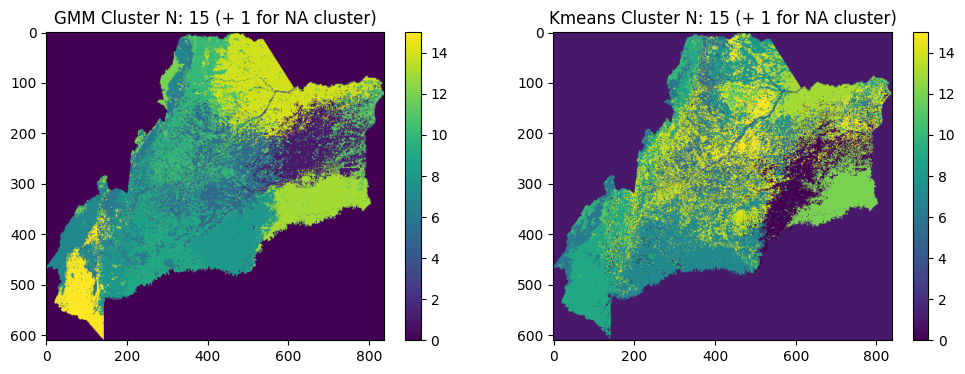

In [ ]:
chosen_n = 15



## DONT CHANGE below !!!







from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


if 9999 in scaled:
  chosen_n = chosen_n+1
  print(f'FYI: your array contains missing values. So your cluster number in your output will be set to {chosen_n} clusters to give the missing values an extra cluster. This extra cluster you can delete in the end after exporting.')
else:
  chosen_n = chosen_n


  ## GMM
gmm = GaussianMixture(n_components = chosen_n, random_state=2025).fit(scaled) #change n_components depending on desicion
labelsgmm = gmm.predict(scaled) #predicting


  ## or Kmeans

kmeans = KMeans(n_clusters= chosen_n, random_state=42).fit(scaled)
labelskm = kmeans.labels_


# now we convert the GMM output back to an array that we can map

#first we check again how our data looked like before the reshaping we did for the cluster tendency test

# print('We need that shape: ', himg_np.shape) # we need that shape
# print('Our current shape:', scaled.shape)


neededshape =  himg_np.shape
newshape = neededshape[:2]
# print(newshape)

clusteredimg_gmm = labelsgmm.reshape(newshape) # back to 3d #for los llanos: 611, 838,
clusteredimg_kmeans= labelskm.reshape(newshape) # back to 3d #for los llanos: 611, 838,

# print('Shape after transforming: ',clusteredimg_gmm.shape)


#plotting

import matplotlib as mpl
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



if 9999 in scaled:

# Plot the first map on ax1
  img1 = ax1.imshow(clusteredimg_gmm, aspect='auto')
  ax1.set_title(f"GMM Cluster N: {chosen_n-1} (+ 1 for NA cluster)")
  plt.colorbar(img1, ax=ax1)

  # Plot the second map on ax2
  img2 = ax2.imshow(clusteredimg_kmeans, aspect='auto')
  ax2.set_title(f"Kmeans Cluster N: {chosen_n-1} (+ 1 for NA cluster)")
  plt.colorbar(img2, ax=ax2)
  plt.show()

else:

# Plot the first map on ax1
  img1 = ax1.imshow(clusteredimg_gmm, aspect='auto')
  ax1.set_title(f"GMM Cluster N: {chosen_n}")
  plt.colorbar(img1, ax=ax1)

  # Plot the second map on ax2
  img2 = ax2.imshow(clusteredimg_kmeans, aspect='auto')
  ax2.set_title(f"Kmeans Cluster N: {chosen_n}")
  plt.colorbar(img2, ax=ax2)

  plt.show()

You can export the arrays (clusteredimg_kmeans & clusteredimg_gmm) as tiff. You will then upload it to your drive.



In [ ]:
## EXPORTING. NO NEED TO CHANGE



if 9999 in scaled:


  export_array_to_geotiff(exportingarray=clusteredimg_kmeans, output_file = f"kmeans_{chosen_n-1}_cluster.tif")
  export_array_to_geotiff(exportingarray=clusteredimg_gmm, output_file = f"gmm_{chosen_n-1}_cluster.tif")

else:
  export_array_to_geotiff(exportingarray=clusteredimg_kmeans, output_file = f"kmeans_{chosen_n}_cluster.tif")
  export_array_to_geotiff(exportingarray=clusteredimg_gmm, output_file = f"gmm_{chosen_n}_cluster.tif")

{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.93334680999999, 1.6177319440000653], [-67.40980314699993, 1.6177319440000653], [-67.40980314699993, 7.104380671000051], [-74.93334680999999, 7.104380671000051], [-74.93334680999999, 1.6177319440000653]]]}


KeyboardInterrupt: 

# Boundary Line Analysis (BLA)

After the clustering we exported our Raster tiffs and uploaded them to the drive, so we can use them now again via google colab.

In the first step we need to define which column of our sample data represents the SOC-content on which the BLA should be based on. If you are not sure, just run this snippet and you will get the column names anyways printed below. Running this snippet gives us also an overview of the sample data mapped on the clustered map.


Column names of your samples:  ['id_prfl', 'SOCst30', 'geometry']


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


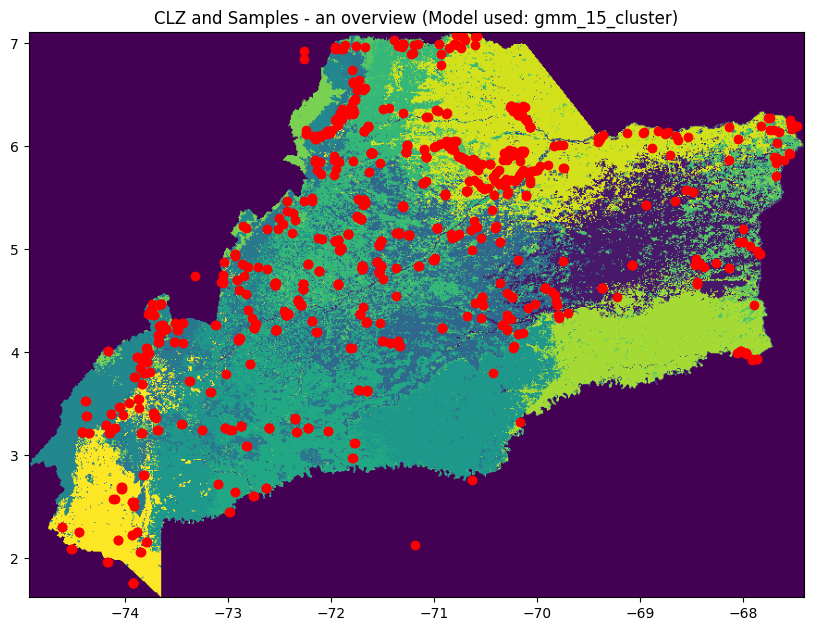

In [ ]:
## defining your paths for shapefile and tiffs and your SOC-column


raster_path = "/content/drive/MyDrive/CIAT/gmm_15_cluster.tif" #change your path to your clustered tiff in your drive (via google colab)



soc_column = "SOCst30"             #change to your soc column for the BLA





## DONT CHANGE Below !!!








import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import tifffile as tiff
import os


modelused = os.path.splitext(os.path.basename(raster_path))[0]

##reading files

stock_soc_shp = gpd.read_file(shp_path)


samples = stock_soc_shp



# aoi_r = tiff.imread(raster_path)
# aoi_r = gdal.Open(raster_path)
aoi_r = rasterio.open(raster_path)

with rasterio.open(raster_path) as src:
  transform = src.transform



## first overview of your data and sample distribution

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f"CLZ and Samples - an overview (Model used: {modelused})")
samples.plot(ax=ax, color="red")
show(aoi_r, ax=ax)


if samples.crs != src.crs:
    src = src.to_crs(samples.crs)

column_names = list(samples.columns)
print("Column names of your samples: ", column_names)










## extraction of rastervalues (cluster number/CLZ) for the samples
aoi_r = rasterio.open(raster_path)

bounds = aoi_r.bounds
samples = samples[samples.geometry.x.between(bounds.left, bounds.right) &
                  samples.geometry.y.between(bounds.bottom, bounds.top)]
#extracting
raster_values = []

for point in samples['geometry']:
  x = point.xy[0][0]
  y = point.xy[1][0]
  row, col = aoi_r.index(x,y)
  value = aoi_r.read(1)[row, col]
  raster_values.append(value)

samples['ClusterNumber'] = raster_values
# plt.imshow(aoi_r.read(1))




Here we start the BL where you can change the precentiles (e.g. ".80" for 80%). You will get a table and a plot to have a look on the results.

               count        mean         std        min        50%  \
ClusterNumber                                                        
0               12.0  102.188132  106.546240  20.367544  44.466140   
1               40.0   71.132765   45.750616  14.520293  52.335360   
2                9.0   46.079944   25.025721  13.025622  49.658141   
3                3.0   22.126732    9.453097  15.252378  18.220988   
4                3.0   58.564278   28.258641  26.021084  72.772821   
5              156.0   70.124279   53.153804   9.533164  62.155436   
6               83.0   42.471142   21.651650  11.160985  37.932750   
7               67.0   90.974344  100.085625  10.633437  59.082105   
8               20.0   73.282143   48.803504  12.686950  56.120839   
9               62.0   69.484671   57.386597  16.354420  52.730245   
10             143.0   65.200843   62.381827   4.529031  51.278342   
11              43.0   58.473537   44.089539   6.981382  41.218640   
12              23.0

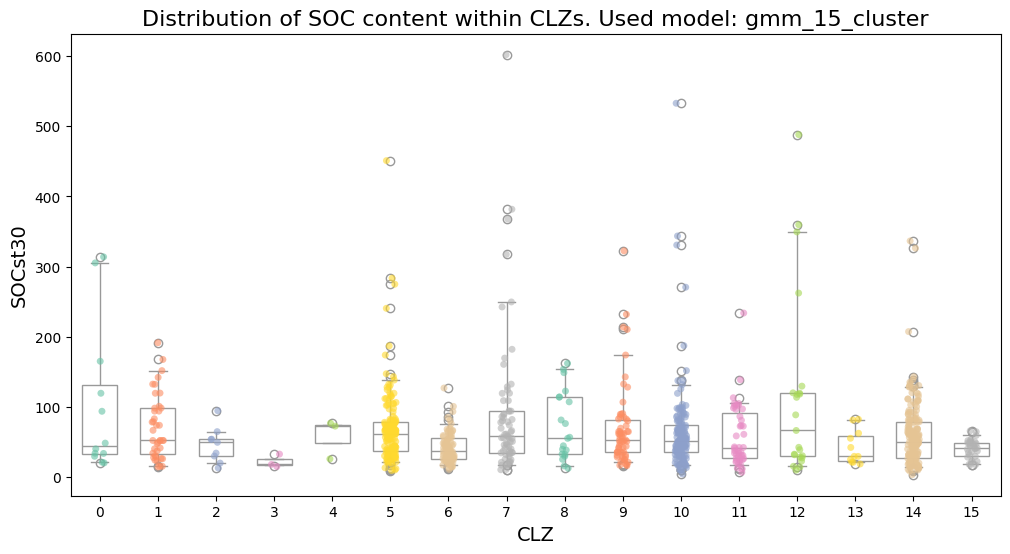

In [ ]:
percentiles = [.80, .85, .90, .95] #change here the percentiles as eg. [.80, .85, .90, .95]



## DONT CHANGE below !!







grouped_descriptions = samples.groupby('ClusterNumber')[soc_column].describe(percentiles=percentiles)
print(grouped_descriptions)



import seaborn as sns
import matplotlib.pyplot as plt

# Plot erstellen
plt.figure(figsize=(12, 6))

# Boxplot
sns.boxplot(x='ClusterNumber', y=soc_column, color="white", data=samples, whis=[5, 95], width=0.6, showcaps=True)

# Stripplot mit Jitter
sns.stripplot(x='ClusterNumber', y=soc_column, hue='ClusterNumber', data=samples,
              jitter=True, palette='Set2', alpha=0.6, size=5, legend = False)

# Achsentitel hinzufügen
plt.xlabel('CLZ', fontsize=14)
plt.ylabel(soc_column, fontsize=14)
plt.title(f'Distribution of SOC content within CLZs. Used model: {modelused}', fontsize=16)

# Plot anzeigen
plt.show()



Here you can get an overview of the distribution of the SOC-content within your CLZ.

Finally you choose here which percentile you want to use for your final SOC potential calculation. In case you want to use all, you need to repeat this step and change the "chosen_percentil". This step also exports your final boundary line maximum SOC tif, if you like (set True or False in the function below).

The "chosen_percentil" is based on the list you made before the "percentiles"-list. In case you are not sure anymore on which you decided, you can run the code anyways and it prints you the list again. E.g.: [0.8, 0.85, 0.9, 0.95]. This list you have to index depending on which percentil you choose. Remember that python indexes with 0 as first position.

Your chosen percentils in a list:  [0.8, 0.85, 0.9, 0.95]
                    95%  Cluster
RasterValue                     
0            309.149868        0
1            152.615316        1
2             82.744726        2
3             31.438246        3
4             76.486317        4
{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.93334680999999, 1.6177319440000653], [-67.40980314699993, 1.6177319440000653], [-67.40980314699993, 7.104380671000051], [-74.93334680999999, 7.104380671000051], [-74.93334680999999, 1.6177319440000653]]]}
| 0.01, 0.00,-74.94|
| 0.00,-0.01, 7.11|
| 0.00, 0.00, 1.00|


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

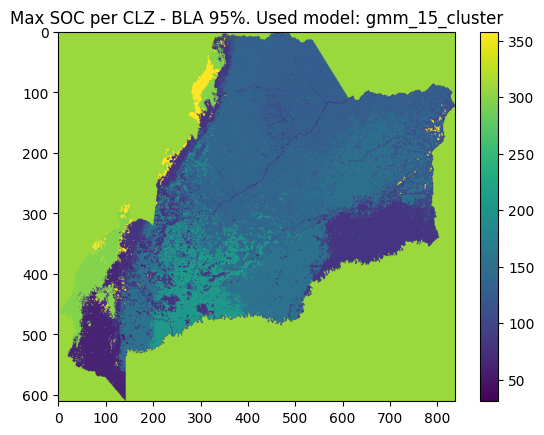

In [ ]:
print("Your chosen percentils in a list: ", percentiles) #your list with the percentiles that we below will index


boundaryline(chosen_percentil=3, export = True)  # indexing in python starts with 0. So if you want the 3rd percentil in your list you will set 4 a chosen_percentil






Your exported tifs have to uploaded now to your GEE account as Assets.

# Potential SOC content

## Preparing current SOC stock

Here the SOILGRIDS data is being prepared. Converting units etc. Don't change anything if you use the Soilgrid data for 30cm depth in ton/ha.

In [ ]:
## DONT CHANGE below !!






bd1_gcm3 = bdclip.select(["bdod_0-5cm_mean"]).multiply(0.01) # in g/cm³
bd2_gcm3 = bdclip.select(["bdod_5-15cm_mean"]).multiply(0.01)
bd3_gcm3 = bdclip.select(["bdod_15-30cm_mean"]).multiply(0.01)

bd_ee = ((bd1_gcm3.multiply(5-0)).add(bd2_gcm3.multiply(15-5)).add(bd3_gcm3.multiply(30-15))).divide(30) #bulk density in g/cm³ for 30cm


soc_5 = socclip.select('soc_0-5cm_mean').multiply(0.0001) #in kg/kg
soc_0_15 = socclip.select('soc_5-15cm_mean').multiply(0.0001)
soc_0_30 = socclip.select('soc_15-30cm_mean').multiply(0.0001)

soc_ee = ((soc_5.multiply(5-0)).add(soc_0_15.multiply(15-5)).add(soc_0_30.multiply(30-15))).divide(30)

soc_stock_ee = soc_ee.multiply(bd_ee).multiply(30).multiply(100).rename("soc_stock_ton_ha") # ton/ha

Have a look on the current stock map if you like.

In [ ]:
map = geemap.Map()
map.addLayer(soc_stock_ee, vis_soc_tonha, "Current SOC stock (30cm) [ton/ha]")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Looking at max and minimum values of the current stock SOC.

In [ ]:
#getting value range
stat_dict = soc_stock_ee.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=soc_stock_ee.geometry(),
    scale=1000,
    maxPixels=1e9
)


min_max_values = stat_dict.getInfo()
print("Min-/Max- Values of the current SOC stock map:", min_max_values)

KeyboardInterrupt: 

## Calculating SOC potential

Now we import from GEE our maximum SOC content map. We calculate here the potential SOC content by subtracting the current SOC content map by the maximum SOC map from the Boundary Line Analysis. Make sure to have the same units (in this case ton/ha)

In [ ]:
path_gee_image = "projects/ee-socseqhotspots/assets/gmm_15_cluster_95_maxSOC_allsamples"

socbl = ee.Image(path_gee_image)  #change your path to the uploaded tiff

drive_export_folder = "GEE_Export" #change to your drive folder
scale = 1000 #set your scale




## DONT CHANGE below !!!








socblclip = socbl.clip(aoigeo)


# then we will substract to create the SOC potential
socpot = socblclip.subtract(soc_stock_ee)





You can export the potential SOC content map now to your drive.

In [ ]:
#export




### DONT CHANGE BELOW !!!!!






filename = path_gee_image.split("/")[-1]
newfilename = filename.replace("max", "pot")
geemap.ee_export_image_to_drive(image = socpot, description = newfilename, folder=drive_export_folder, region=aoigeo, scale=scale)


And have a look on it:

In [ ]:
# map = geemap.Map()



map.addLayer(socblclip, vis_soc_tonha, "BL max SOC per Cluster")
map.addLayer(socpot, vis_soc_tonha, "Potential SOC per Cluster")


map

Map(bottom=16267.0, center=[4.577287979407777, -71.10913876926482], controls=(WidgetControl(options=['position…